# CNN 遥感图像分类项目

## 数据说明
This is a 21 class land use image dataset meant for research purposes. 
There are 100 images for each of the following classes:
+ agricultural
+ airplane
+ baseballdiamond
+ beach
+ buildings
+ chaparral
+ denseresidential
+ forest
+ freeway
+ golfcourse
+ harbor
+ intersection
+ mediumresidential
+ mobilehomepark
+ overpass
+ parkinglot
+ river
+ runway
+ sparseresidential
+ storagetanks
+ tenniscourt

Each image measures 256x256 pixels.

The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

Download site: http://weegee.vision.ucmerced.edu/datasets/landuse.html

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from skimage.transform import resize
import cv2

from PIL import Image
import os
from shutil import copyfile

In [2]:
#!pip freeze 

In [3]:
print(keras.__version__)

2.4.0


# Model Visualization

Reference: 
1. https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/
2. https://cs231n.github.io/understanding-cnn/

load saved model

In [4]:
save_file = 'model/MultiClass_3Conv1Den_dataAugm_NormBatch_20201110_232446_ACC93.12.h5'

In [5]:
model = load_model(save_file)

The model summary summarizes the layer name, the output shape of each layer, e.g. the shape of the resulting feature maps and # of parameters.

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 128)      

We can access all of the layers of the model via the model.layers property.

In [7]:
for i in range(len(model.layers)):
	layer = model.layers[i]
	print(i, layer.name, layer.output.shape)

0 conv2d_3 (None, 64, 64, 64)
1 max_pooling2d_3 (None, 32, 32, 64)
2 batch_normalization_2 (None, 32, 32, 64)
3 activation_2 (None, 32, 32, 64)
4 conv2d_4 (None, 32, 32, 128)
5 max_pooling2d_4 (None, 16, 16, 128)
6 batch_normalization_3 (None, 16, 16, 128)
7 activation_3 (None, 16, 16, 128)
8 conv2d_5 (None, 16, 16, 256)
9 max_pooling2d_5 (None, 8, 8, 256)
10 flatten_1 (None, 16384)
11 dense_2 (None, 128)
12 dropout_1 (None, 128)
13 dense_3 (None, 8)


## Visualize Filters 

Each convolutional layer has two sets of weights: the filters and the biases.

layer.get_weights() returns a type of python list has two elements: 
+ weight of the layer stored at layer.get_weights()
+ the bias is stored at layer.get_weights()

In [8]:
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_3 (3, 3, 3, 64)
conv2d_4 (3, 3, 64, 128)
conv2d_5 (3, 3, 128, 256)


We can see that all convolutional layers use 3×3 filters. The next number after the filter size is the depth of a filter which matches with the depth of the input for the filter (e.g. the number of channels).

We can retrieve the filters from the first layer as follows:

Filter 0


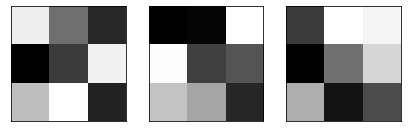

Filter 1


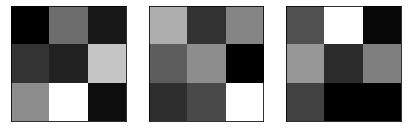

Filter 2


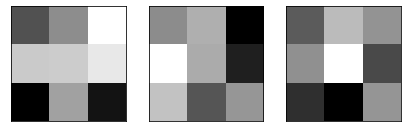

Filter 3


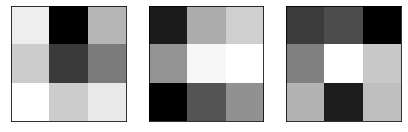

Filter 4


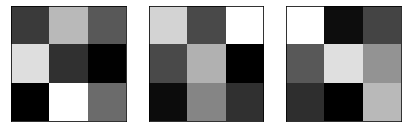

Filter 5


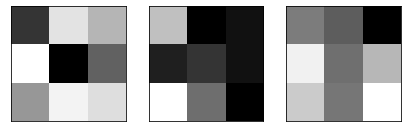

In [9]:
# retrieve weights from the first conv layer
filters, biases = model.layers[0].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first 6 filters
n_filters, ix = 6, 1

for i in range(n_filters):
    # get the filter
    print('Filter',i)
    plt.figure(figsize=(7,40))
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
    # show the figure
    plt.show()

The dark squares indicate small weights and the light squares represent large weights.

## Visualize Feature Maps

The activation maps, called feature maps, capture the result of applying the filters to input, such as the input image or another feature map.

The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps

Load an image from the previous saved np array:

In [10]:
# Load the numpy datasets
images_orig = np.load('data/UCMerced_images_orig_MultiClass.npy')

 Expanded image from a 3D array to a 4D array with the dimensions of [samples, rows, cols, channels], where we only have one sample.

In [11]:
img = images_orig[123].reshape(1,64,64,3)

(-0.5, 63.5, 63.5, -0.5)

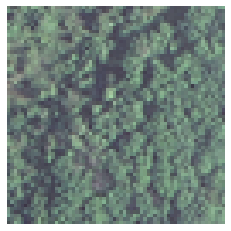

In [12]:
fig = plt.figure(figsize=(4,4))
plt.imshow(img[0,:,:])  
#plt.imshow(img[0,:,:],cmap="gray")
plt.axis('off')

We only need output from the layers before the flatten

In [13]:
model.inputs

[<tf.Tensor 'conv2d_3_input:0' shape=(None, 64, 64, 3) dtype=float32>]

In [14]:
model.layers[0].output

<tf.Tensor 'conv2d_3/BiasAdd:0' shape=(None, 64, 64, 64) dtype=float32>

In [15]:
outputs = [model.layers[i].output for i in range(0,9)]

In [16]:
outputs

[<tf.Tensor 'conv2d_3/BiasAdd:0' shape=(None, 64, 64, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'batch_normalization_2/cond/Identity:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'activation_2/Relu:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'conv2d_4/BiasAdd:0' shape=(None, 32, 32, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_3/cond/Identity:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'activation_3/Relu:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'conv2d_5/Relu:0' shape=(None, 16, 16, 256) dtype=float32>]

In [17]:
model_v = Model(inputs=model.inputs, outputs=outputs)

In [18]:
model_v.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)      

In [19]:
model_v.outputs

[<tf.Tensor 'conv2d_3/BiasAdd:0' shape=(None, 64, 64, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'batch_normalization_2/cond/Identity:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'activation_2/Relu:0' shape=(None, 32, 32, 64) dtype=float32>,
 <tf.Tensor 'conv2d_4/BiasAdd:0' shape=(None, 32, 32, 128) dtype=float32>,
 <tf.Tensor 'max_pooling2d_4/MaxPool:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'batch_normalization_3/cond/Identity:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'activation_3/Relu:0' shape=(None, 16, 16, 128) dtype=float32>,
 <tf.Tensor 'conv2d_5/Relu:0' shape=(None, 16, 16, 256) dtype=float32>]

In [20]:
model.outputs

[<tf.Tensor 'dense_3/Softmax:0' shape=(None, 8) dtype=float32>]

Calling the model.predict() function and passing in the prepared single image.

In [21]:
feature_maps = model_v.predict(img)

Show the predicted feature map shape in each layer

In [22]:
for i in range(len(feature_maps)):
    print(i,feature_maps[i].shape)

0 (1, 64, 64, 64)
1 (1, 32, 32, 64)
2 (1, 32, 32, 64)
3 (1, 32, 32, 64)
4 (1, 32, 32, 128)
5 (1, 16, 16, 128)
6 (1, 16, 16, 128)
7 (1, 16, 16, 128)
8 (1, 16, 16, 256)


Shows all feature maps in each layer as subplots.

We can see that the result of applying the filters in the first convolutional layer is a lot of versions of the image with different features highlighted.

Layer 0:conv2d_3


ValueError: 'RGB' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

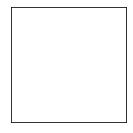

In [33]:
# plot the output from each block
square = 8
i = 0
for fmap in feature_maps:
	plt.figure(figsize=(20,max(20,20*fmap.shape[-1]//(square*square))))
	# plot all maps in an nx8 squares
	ix = 1
	print('Layer {}:{}'.format(i,model.layers[i].name))
	i+=1
	for _ in range(fmap.shape[-1]//square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(fmap.shape[-1]//square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='RGB')
			ix += 1
	# show the figure
	plt.show()

### Another image

In [24]:
img = images_orig[333].reshape(1,64,64,3)

(-0.5, 63.5, 63.5, -0.5)

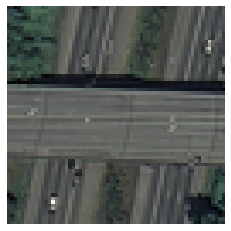

In [25]:
fig = plt.figure(figsize=(4,4))
plt.imshow(img[0,:,:])  
#plt.imshow(img[0,:,:],cmap="gray")
plt.axis('off')

We only need output from the layers before the flatten

In [26]:
outputs = [model.layers[i].output for i in range(0,9)]

In [27]:
model_v = Model(inputs=model.inputs, outputs=outputs)

Calling the model.predict() function and passing in the prepared single image.

In [28]:
feature_maps = model_v.predict(img)

Show the predicted feature map shape in each layer

In [29]:
for i in range(len(feature_maps)):
    print(i,feature_maps[i].shape)

0 (1, 64, 64, 64)
1 (1, 32, 32, 64)
2 (1, 32, 32, 64)
3 (1, 32, 32, 64)
4 (1, 32, 32, 128)
5 (1, 16, 16, 128)
6 (1, 16, 16, 128)
7 (1, 16, 16, 128)
8 (1, 16, 16, 256)


Shows all feature maps in each layer as subplots.

We can see that the result of applying the filters in the first convolutional layer is a lot of versions of the image with different features highlighted.

Layer 0:conv2d_3


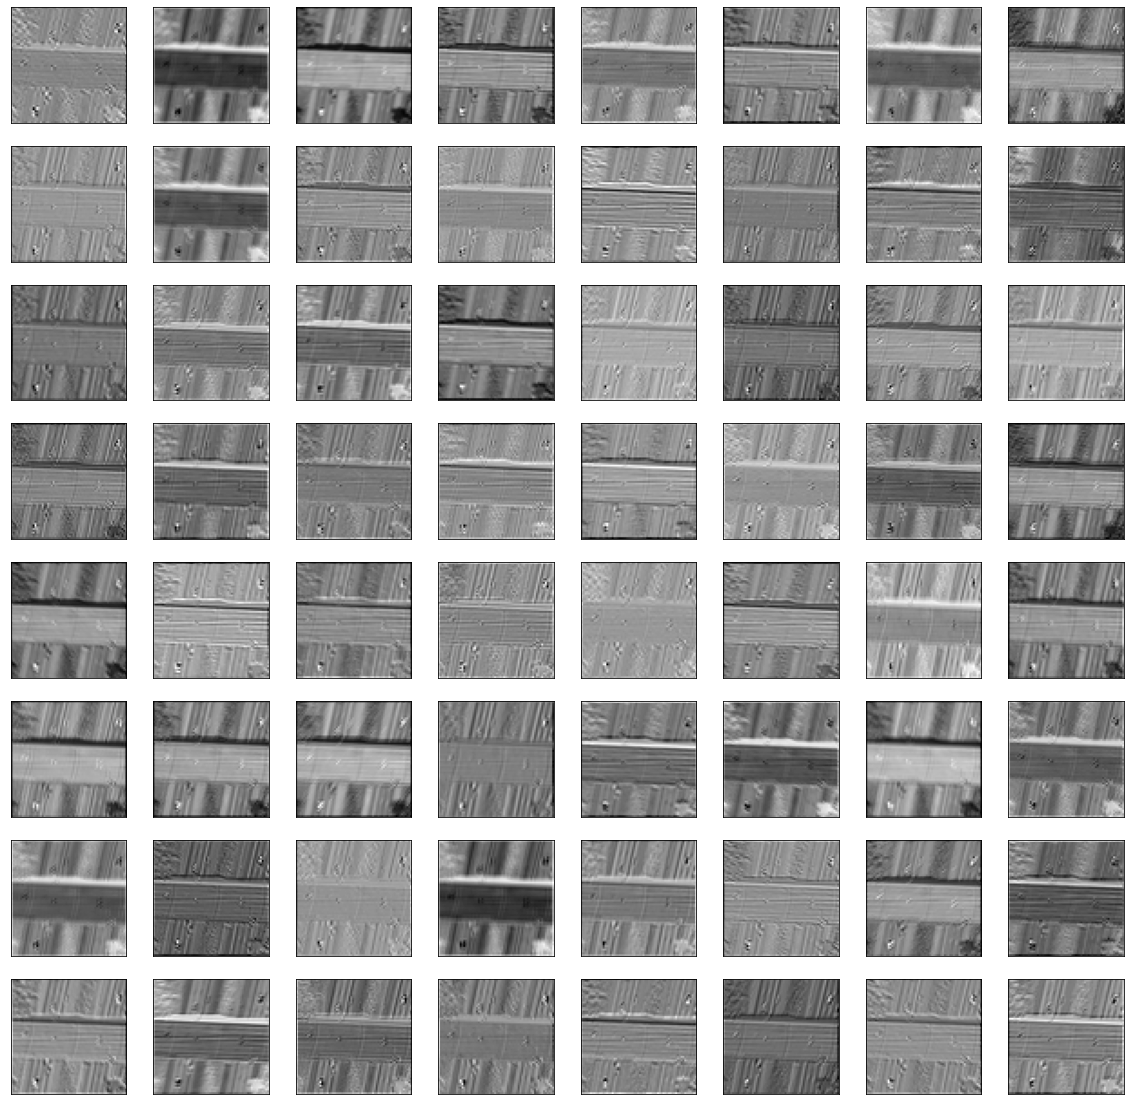

Layer 1:max_pooling2d_3


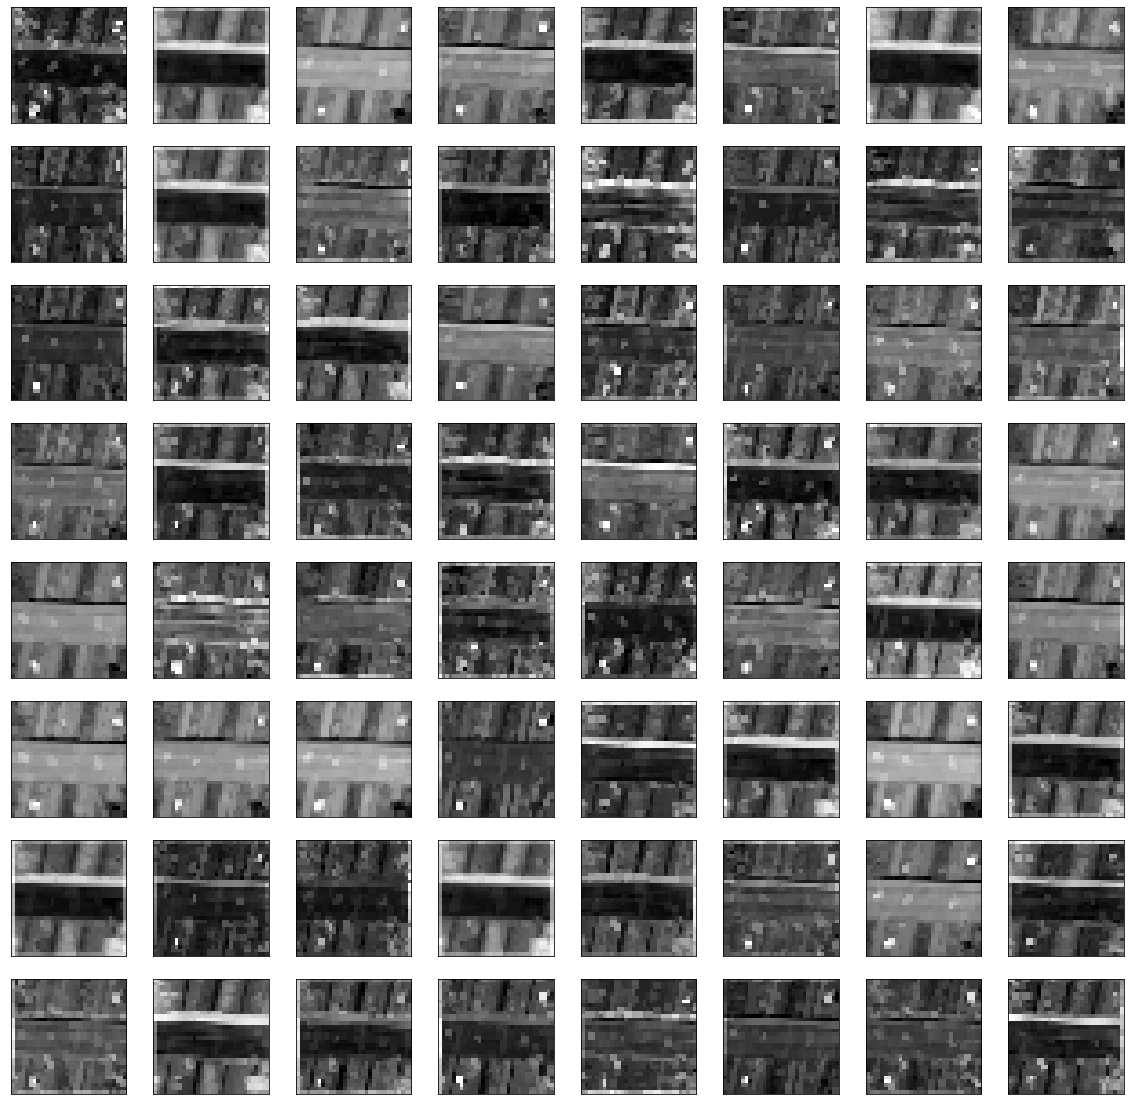

Layer 2:batch_normalization_2


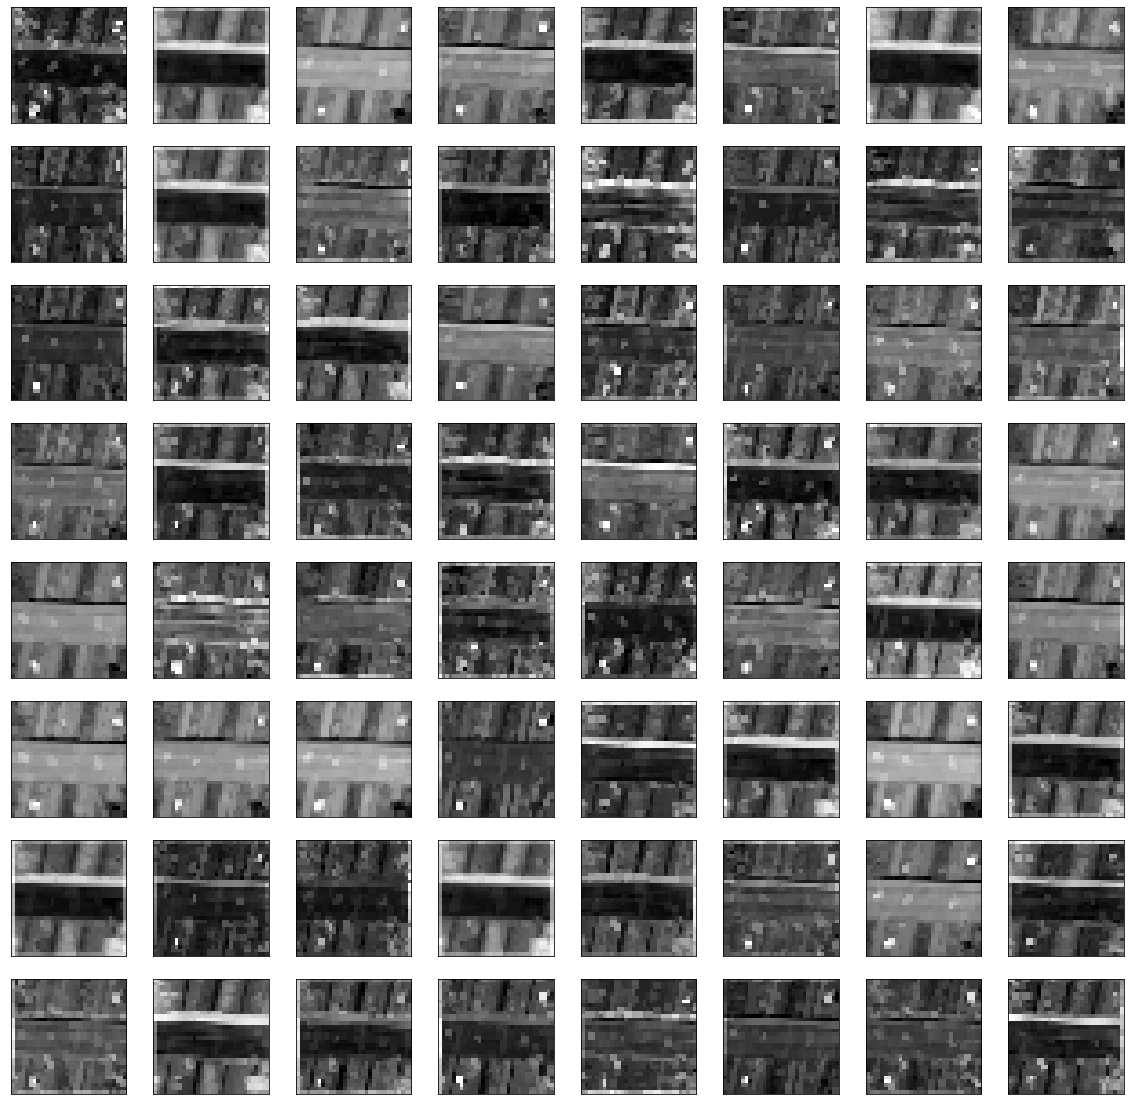

Layer 3:activation_2


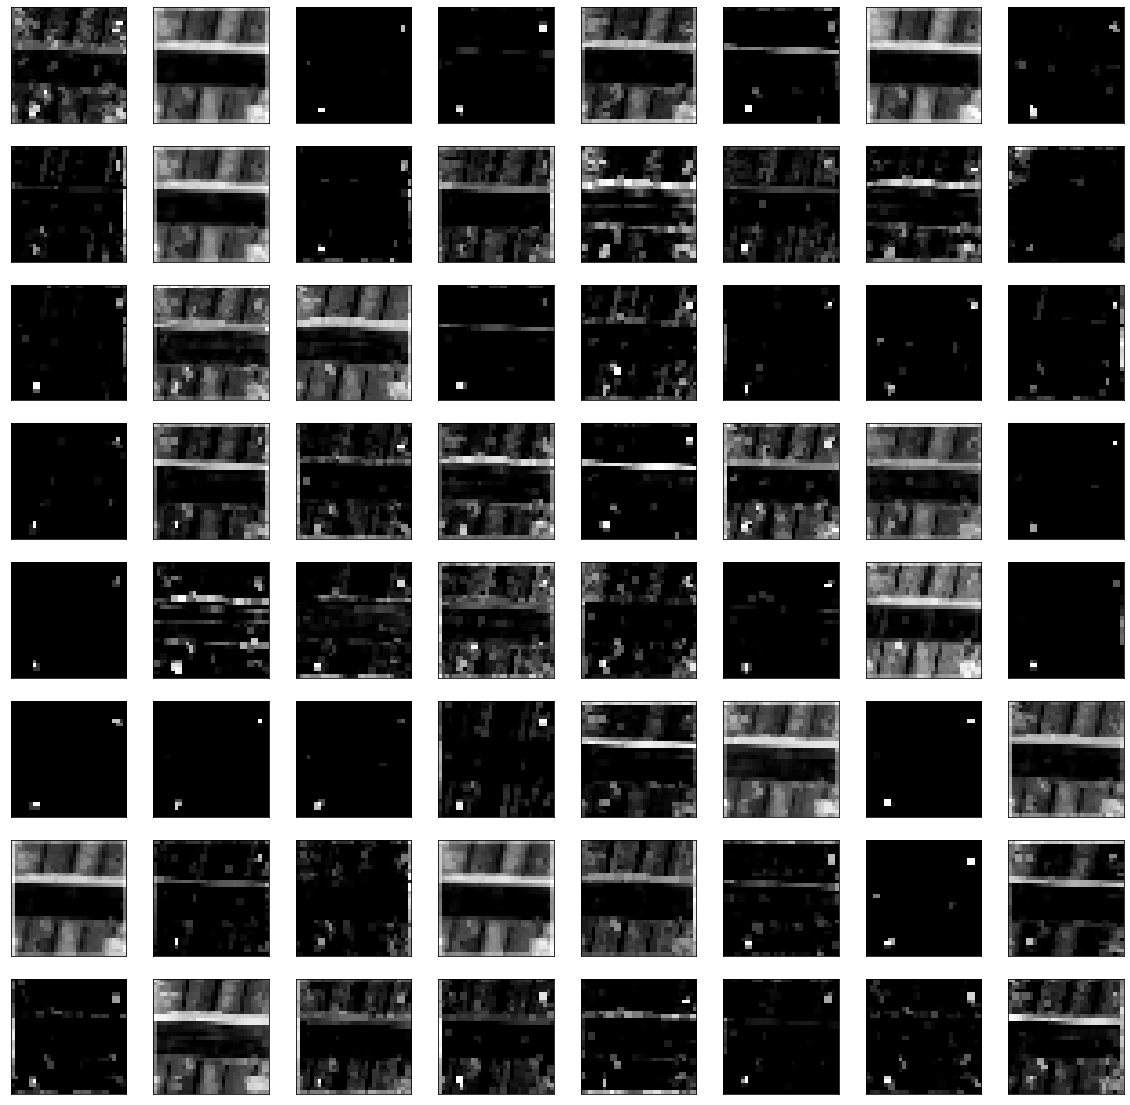

Layer 4:conv2d_4


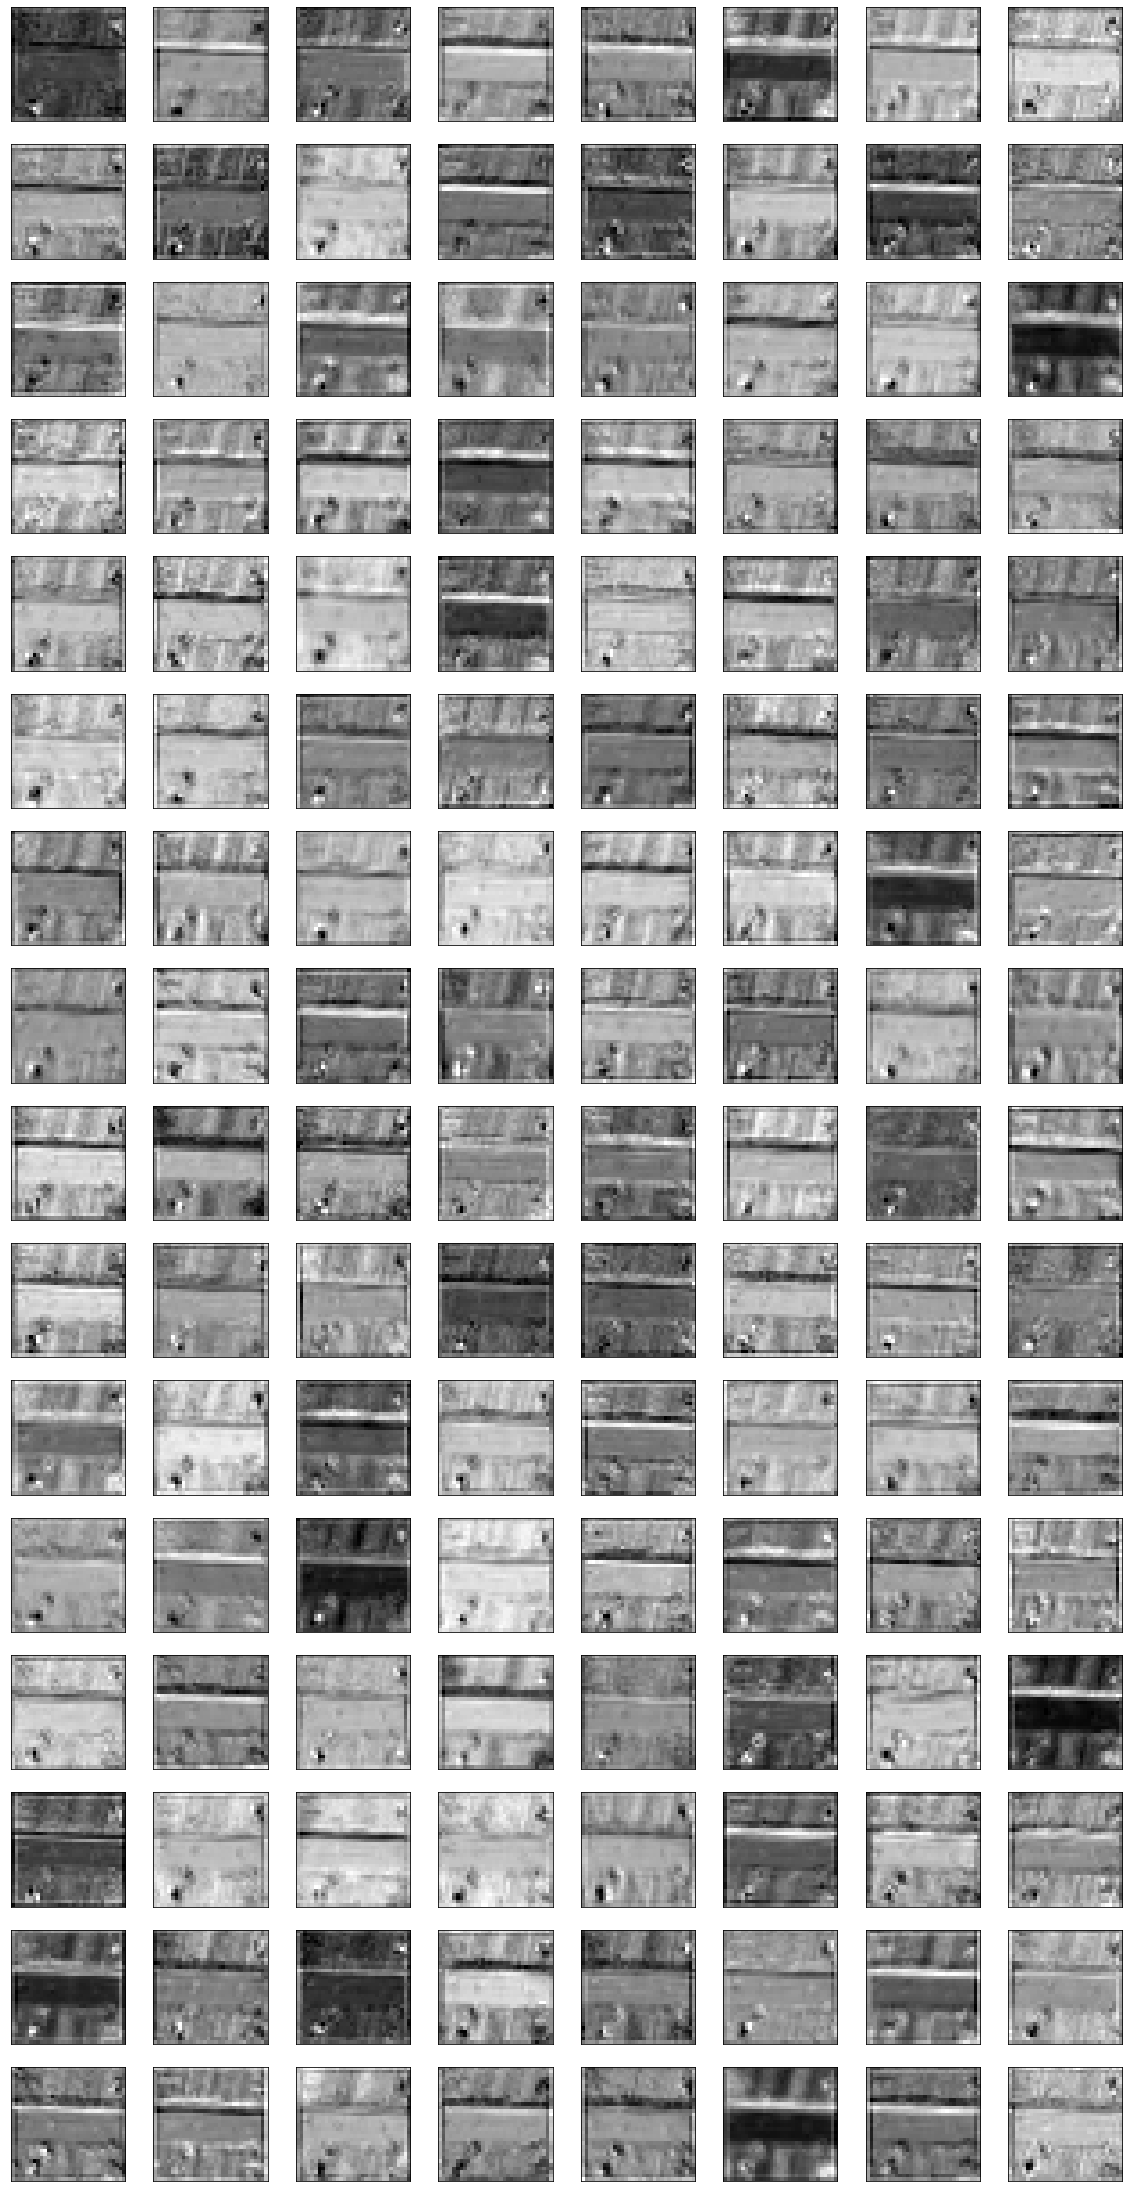

Layer 5:max_pooling2d_4


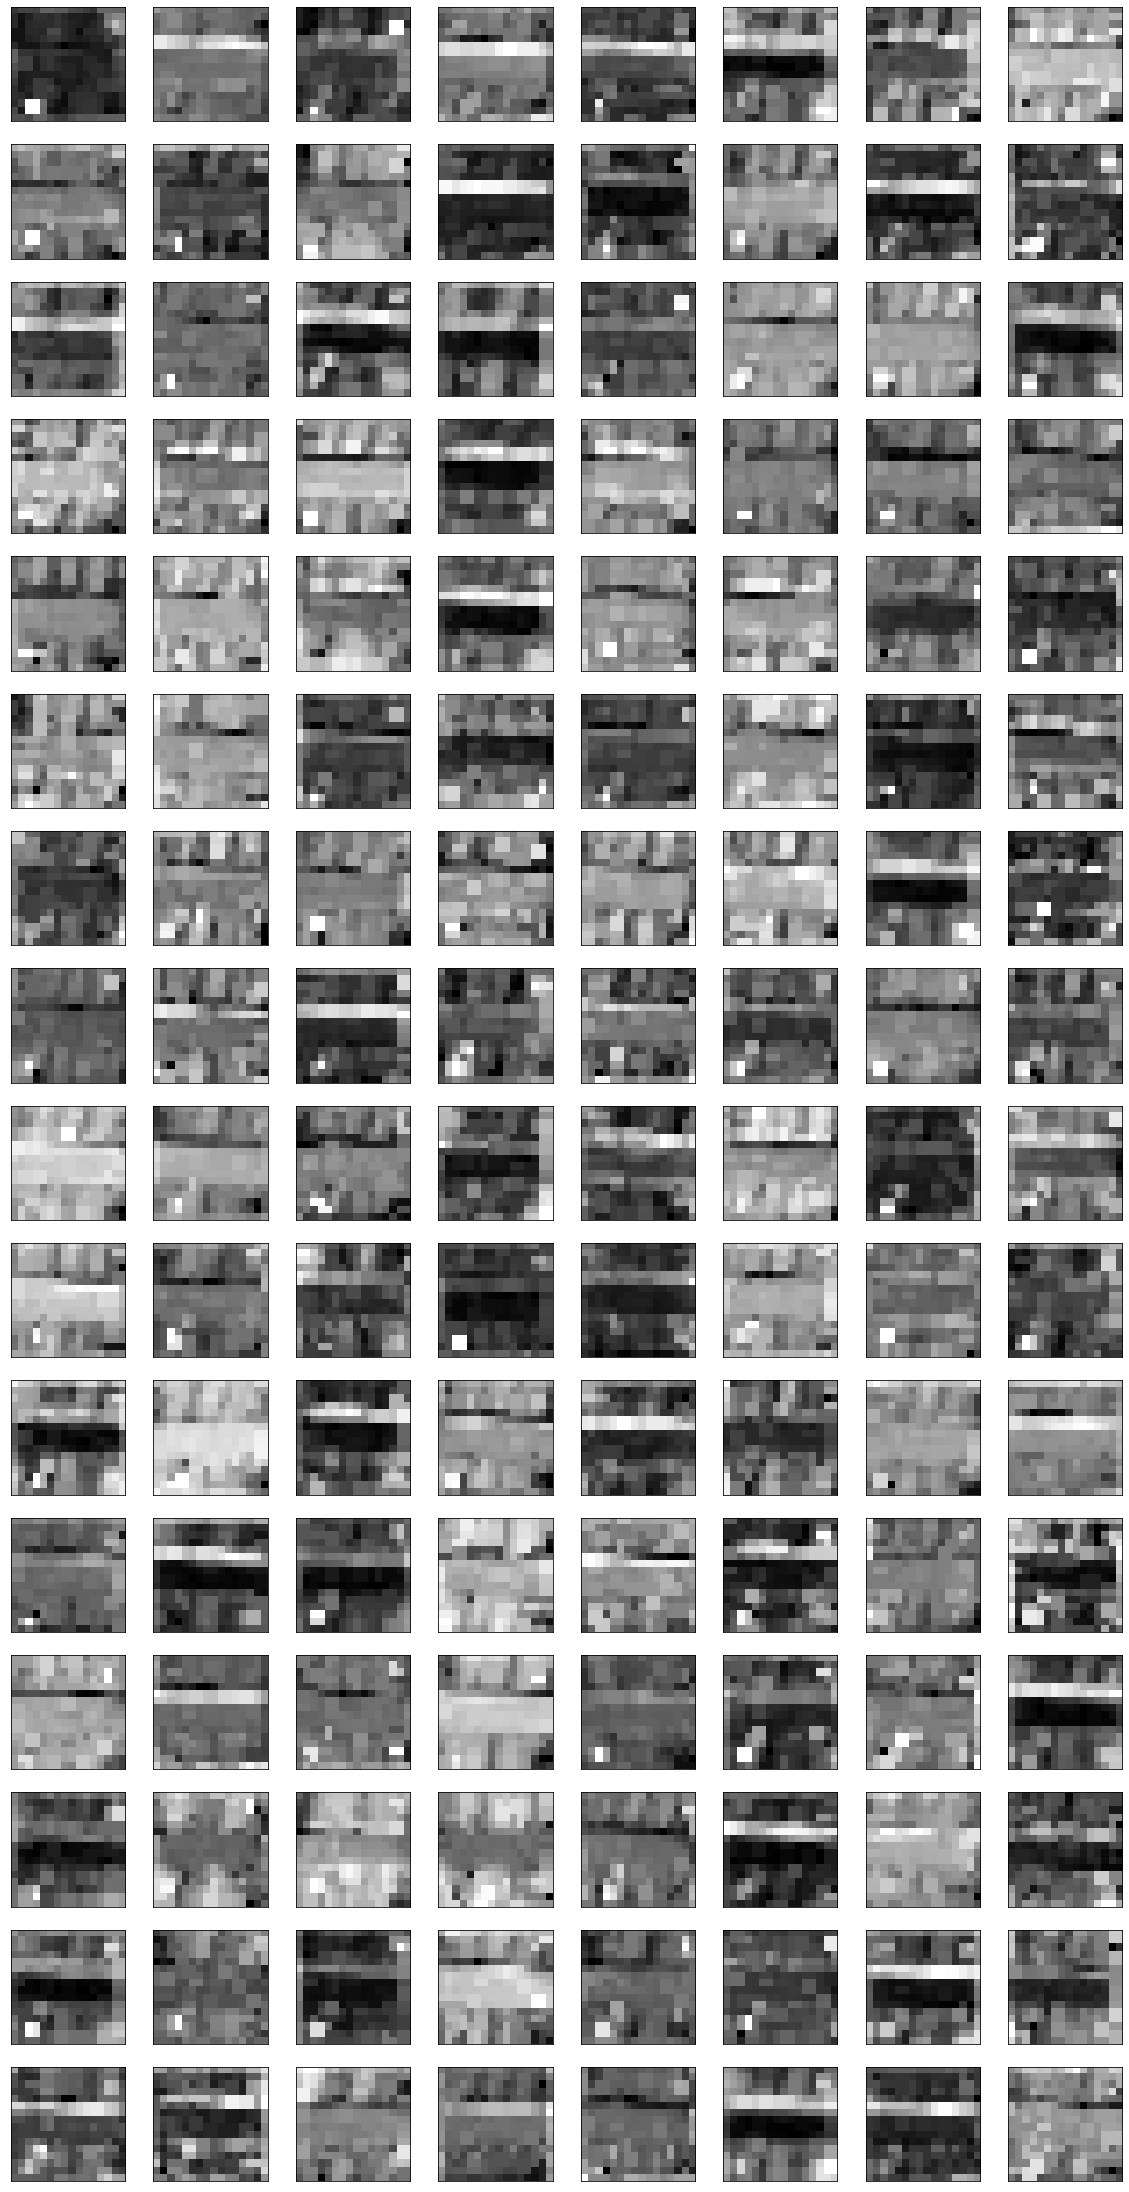

Layer 6:batch_normalization_3


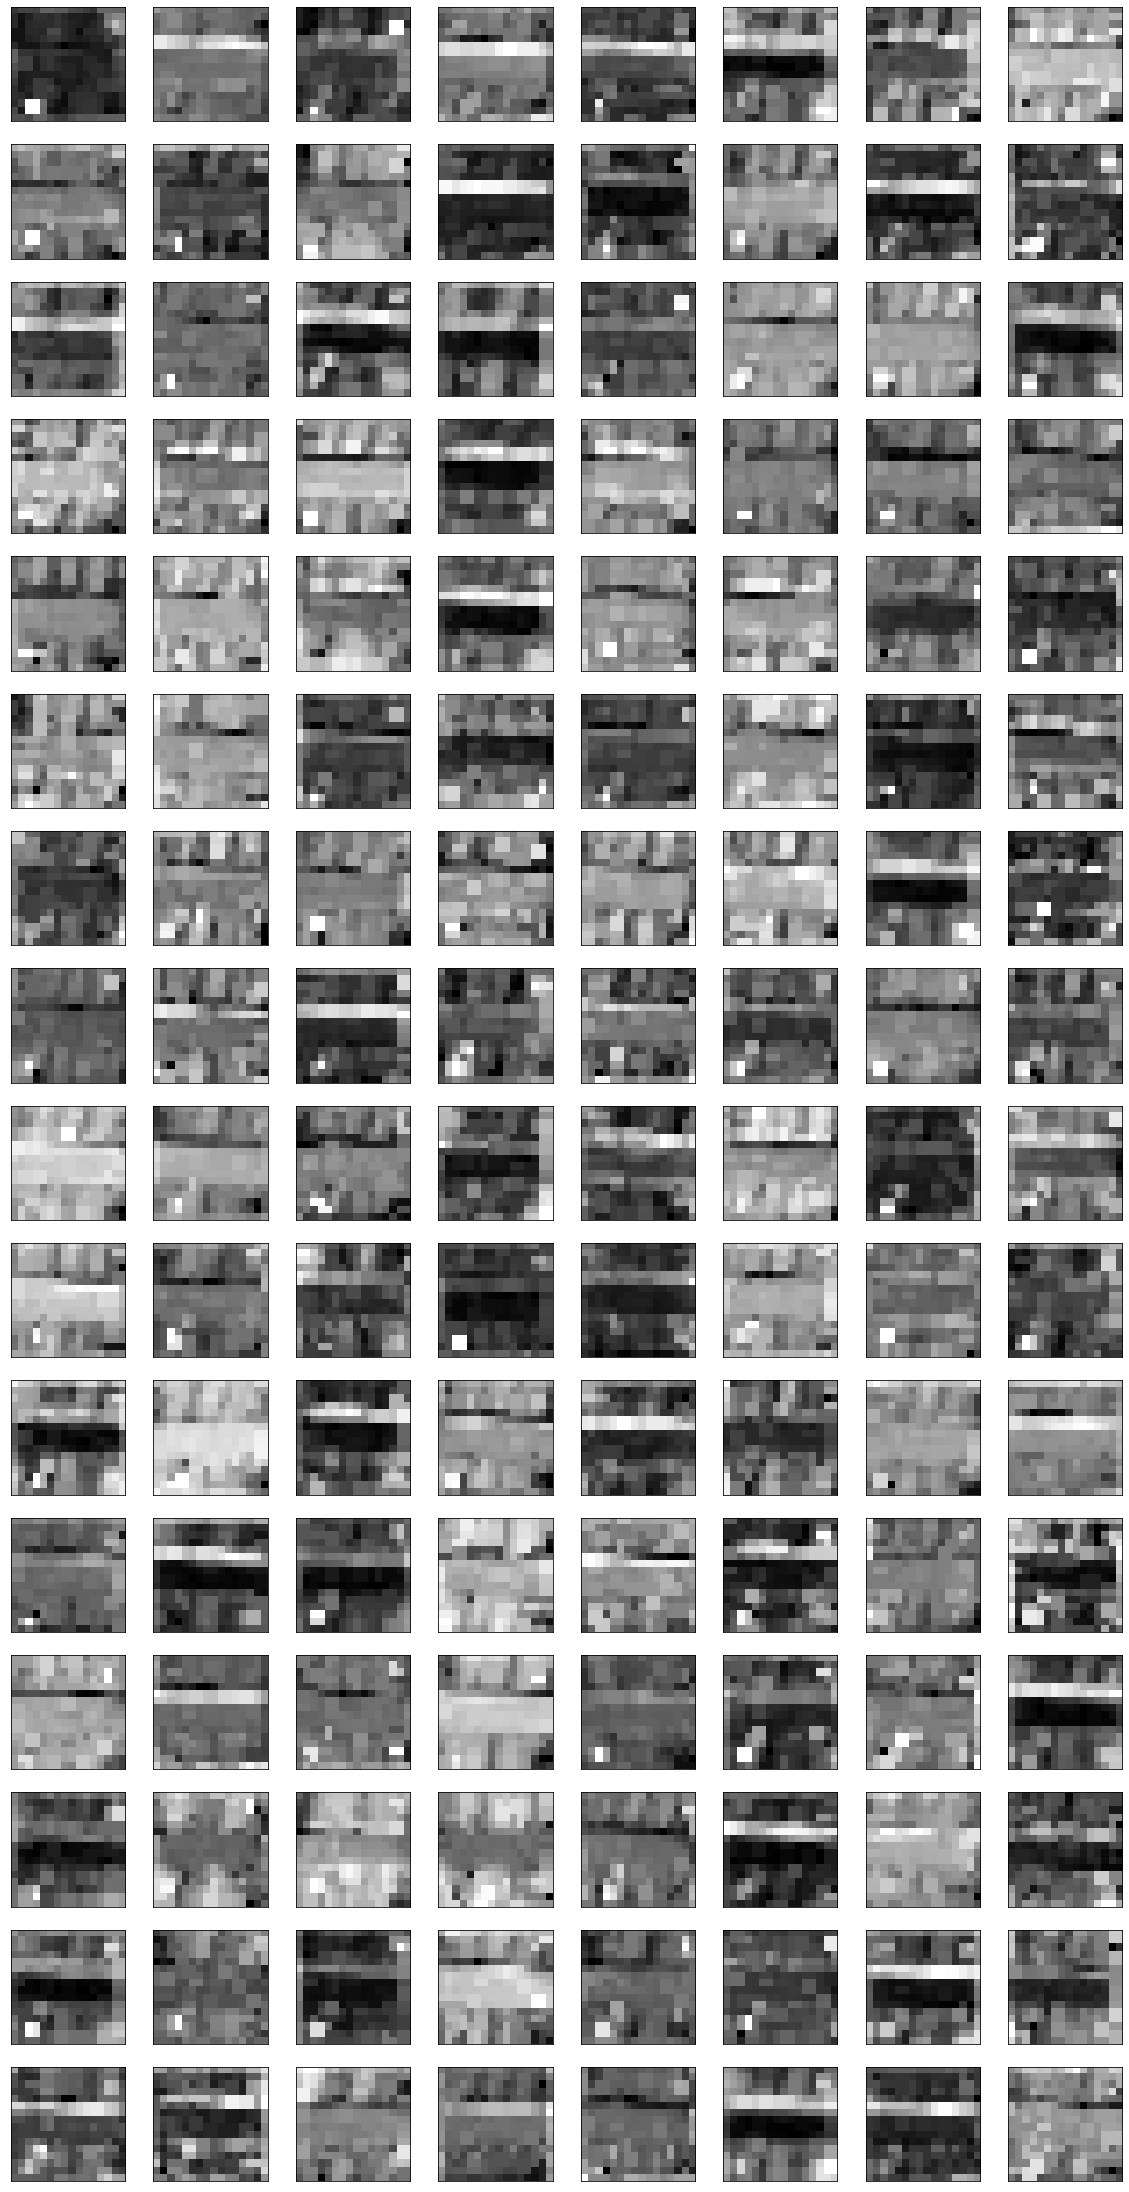

Layer 7:activation_3


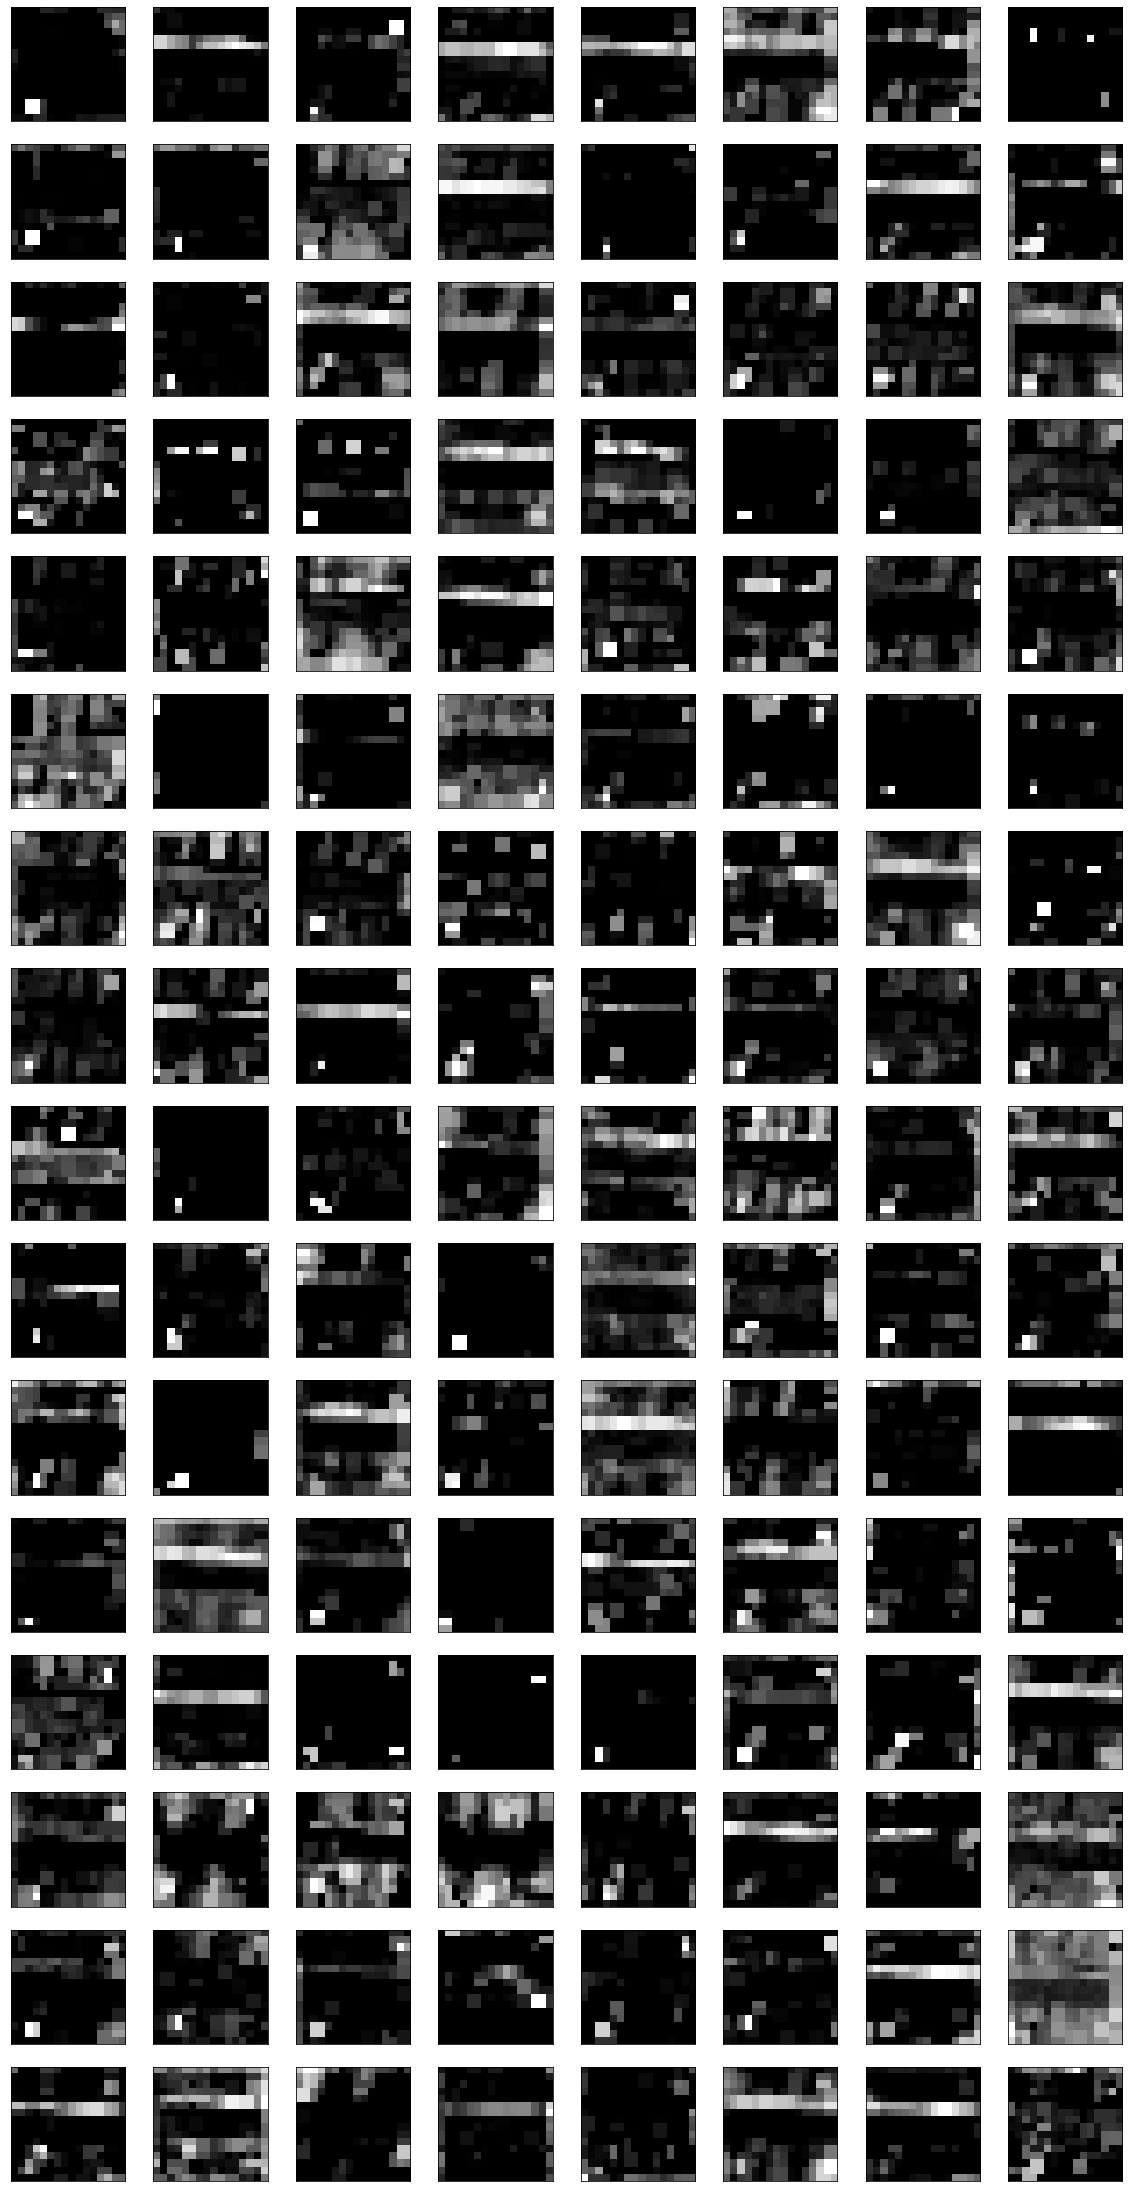

Layer 8:conv2d_5


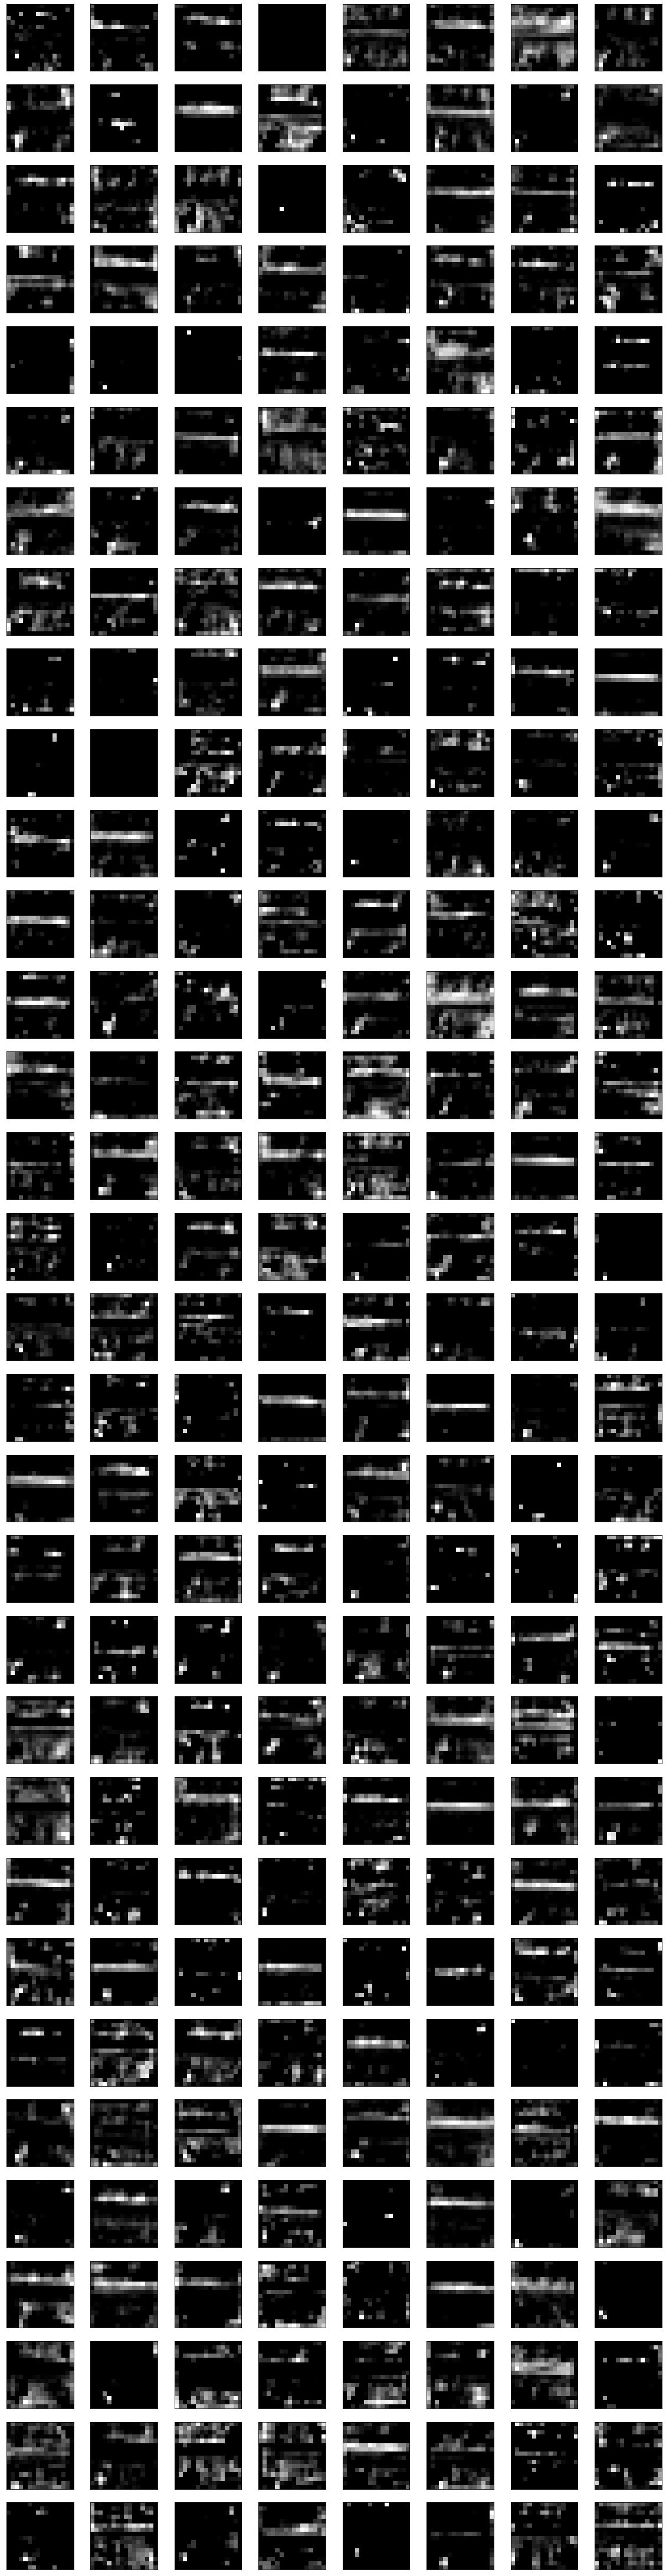

In [30]:
# plot the output from each block
square = 8
i = 0
for fmap in feature_maps:
	plt.figure(figsize=(20,max(20,20*fmap.shape[-1]//(square*square))))
	# plot all maps in an nx8 squares
	ix = 1
	print('Layer {}:{}'.format(i,model.layers[i].name))
	i+=1
	for _ in range(fmap.shape[-1]//square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = plt.subplot(fmap.shape[-1]//square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	plt.show()